<a href="https://colab.research.google.com/github/Zilch123/Aruco-3D-position-Validation/blob/main/ArucoValidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Author1: Timoth Dev 
# Author2: Arjun Ram 
# GNU 3.0 Licence 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install opencv-contrib-python
# !git clone https://github.com/ddelago/Aruco-Marker-Calibration-and-Pose-Estimation.git

In [258]:
import os
import sys
import pickle
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2.aruco as aruco
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)


Type in your drive path to Data, path is the same till MyDrive

In [4]:
cd drive/MyDrive/Aruco\ CMC\ project/Data/

/content/drive/.shortcut-targets-by-id/1bOHe3Wct63zxzPGjAqK-HttE3BVPIieY/Data


In [5]:
ls Subject\ 1/Subject\ 1/Sub\ 1\ SB

color.pickle  subject1.avi              subject1_color.avi  subject1_depth.avi
prm.pickle    subject1_color_aruco.avi  subject1_color.mp4  xyz.pickle


In [6]:
def read_calib(RotMatrix):
    return np.matrix(RotMatrix[0]), np.matrix(RotMatrix[1]).T

def kinect2table(orig,R_T,kinect_joint):
    Local_co = [np.matmul(R_T.T,(x-orig).T) for x in kinect_joint]
    return(np.array(Local_co).squeeze())


In [7]:
with open("rotMat_new.pickle",'rb') as f:
    RotMatrix = []
    while True:
        try:
            RotMatrix.append(pickle.load(f))
        except EOFError:
            break

In [8]:
orig, R_T = read_calib(RotMatrix)

In [9]:
print(orig, R_T, RotMatrix)

[[-0.141 -0.251  1.404]] [[ 0.99871538 -0.00993747  0.04968733]
 [-0.02327689 -0.95835113  0.27619518]
 [-0.023868   -0.27631295 -0.96077129]] [array([-0.141, -0.251,  1.404]), array([[ 0.99871538, -0.02327689, -0.023868  ],
       [-0.00993747, -0.95835113, -0.27631295],
       [ 0.04968733,  0.27619518, -0.96077129]])]


In [249]:
# https://github.com/ddelago/Aruco-Marker-Calibration-and-Pose-Estimation
# Load the Github camera calib profile 
f = open("Aruco-Marker-Calibration-and-Pose-Estimation/calibration/CameraCalibration.pckl", 'rb')
(cameraMatrix, distCoeffs, _, _) = pickle.load(f, encoding='latin1')
f.close()

# Kinect Calib data
# https://github.com/shanilfernando/VRInteraction/blob/master/calibration/rgb_calibration.yaml
# cameraMatrix = np.array([[ 1.0327407219495085e+03, 0., 9.5685930301206076e+02],
#                          [ 0., 1.0323427647512485e+03, 5.3914133979587950e+02],
#                          [0., 0., 1. ]])
# distCoeffs=np.array([[ 2.0429028189430772e-02, -7.8399448855923665e-03, 
#                      -3.0949667668667908e-03, 2.1848647826377197e-03, -5.2344198896187882e-02 ]])

print(cameraMatrix, distCoeffs )


[[1.44095165e+03 0.00000000e+00 9.40438869e+02]
 [0.00000000e+00 1.43677267e+03 5.27992515e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] [[ 0.07833557 -0.51920323 -0.00682128 -0.00380227  1.04236729]]


In [250]:

# Constant parameters used in Aruco methods
ARUCO_PARAMETERS = aruco.DetectorParameters_create()
ARUCO_DICT = aruco.Dictionary_get(aruco.DICT_5X5_50)

# Create grid board object we're using in our video
board = aruco.GridBoard_create(
        markersX=1,
        markersY=1,
        markerLength=0.09,
        markerSeparation=0.01,
        dictionary=ARUCO_DICT)

# Create vectors we'll be using for rotations and translations for postures
rotation_vectors, translation_vectors = None, None

#axis is just for visualisation of coordinate frame 
axis = np.float32([[-.5,-.5,0], [-.5,.5,0], [.5,.5,0], [.5,-.5,0],
                   [-.5,-.5,1],[-.5,.5,1],[.5,.5,1],[.5,-.5,1] ])

# https://stackoverflow.com/questions/46363618/aruco-markers-with-opencv-get-the-3d-corner-coordinates?rq=1
def rotate_marker_corners(rvec, markersize, tvec = None):

    mhalf = markersize / 2.0

    # convert rot vector to rot matrix both do: markerworld -> cam-world
    mrv, jacobian = cv2.Rodrigues(rvec)

    #in markerworld the corners are all in the xy-plane so z is zero at first
    X = mhalf * mrv[:,0] #rotate the x = mhalf
    Y = mhalf * mrv[:,1] #rotate the y = mhalf
    minusX = X * (-1)
    minusY = Y * (-1)

    # calculate 4 corners of the marker in camworld. corners are enumerated clockwise
    markercorners = []
    markercorners.append(np.add(minusX, Y)) #was upper left in markerworld
    markercorners.append(np.add(X, Y)) #was upper right in markerworld
    markercorners.append(np.add( X, minusY)) #was lower right in markerworld
    markercorners.append(np.add(minusX, minusY)) #was lower left in markerworld
    # if tvec given, move all by tvec
    if tvec is not None:
        C = tvec #center of marker in camworld
        for i, mc in enumerate(markercorners):
            markercorners[i] = np.add(C,mc) #add tvec to each corner
    #print('Vec X, Y, C, dot(X,Y)', X,Y,C, np.dot(X,Y)) # just for debug
    markercorners = np.array(markercorners,dtype=np.float32) # type needed when used as input to cv2
    return markercorners, mrv

In [267]:
end_video_no =3
kinect_df = {}
for subject_number in range(1,end_video_no):
  kinect_df_ =pd.DataFrame(columns=['time_raw','kx', 'ky', 'kz', 'ax', 'ay', 'az' ])
  (height, width, layers) = (368,432,3)
  fps=14.97
  fourcc = cv2.VideoWriter_fourcc(*'MP42')
  video = cv2.VideoWriter("Subject "+str(subject_number)+"/Subject "+str(subject_number)+
                          "/Sub "+str(subject_number)+" SB/subject"+str(subject_number)+"_color_aruco.avi", fourcc, float(fps), (width, height))
  # video = cv2.VideoWriter("'drive'/'MyDrive'/'Aruco CMC project'/'subject1.mp4'", fourcc, float(fps), (width, height))
  i=0
  with open("Subject "+str(subject_number)+"/Subject "+str(subject_number)+"/Sub "+str(subject_number)+" SB/color.pickle",'rb') as color_img, \
       open("Subject "+str(subject_number)+"/Subject "+str(subject_number)+"/Sub "+str(subject_number)+" SB/xyz.pickle",'rb') as depth_img, \
       open("Subject "+str(subject_number)+"/Subject "+str(subject_number)+"/Sub "+str(subject_number)+" SB/prm.pickle",'rb') as prm:
      while True:
          try:
            # Change RGB to BGR
            color_image = pickle.load(color_img)
            Depth_xyz = pickle.load(depth_img)
            gray = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

            # Detect Aruco markers
            corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, ARUCO_DICT, parameters=ARUCO_PARAMETERS)
            # Refine detected markers
            # Eliminates markers not part of our board, adds missing markers to the board
            corners, ids, rejectedImgPoints, recoveredIds = aruco.refineDetectedMarkers(
                image = gray,
                board = board,
                detectedCorners = corners,
                detectedIds = ids,
                rejectedCorners = rejectedImgPoints,
                cameraMatrix = cameraMatrix,
                distCoeffs = distCoeffs)   
            ProjectImage = aruco.drawDetectedMarkers(color_image, corners, borderColor=(0, 0, 255))
            if ids is not None and len(ids) > 0:
              # Estimate the posture per each Aruco marker
              rotation_vectors, translation_vectors, _objPoints = aruco.estimatePoseSingleMarkers(corners, 1, cameraMatrix, distCoeffs)

              markerCorner = np.array((corners)).reshape((4, 2))
              (topLeft, topRight, bottomRight, bottomLeft) = markerCorner

              # convert each of the (x, y)-coordinate pairs to integers
              topRight = (int(topRight[0]), int(topRight[1]))
              bottomRight = (int(bottomRight[0]), int(bottomRight[1]))
              bottomLeft = (int(bottomLeft[0]), int(bottomLeft[1]))
              topLeft = (int(topLeft[0]), int(topLeft[1]))

              # draw the bounding box of the ArUCo detection
              cv2.line(ProjectImage, topLeft, topRight, (0, 255, 0), 2)
              cv2.line(ProjectImage, topRight, bottomRight, (0, 255, 0), 2)
              cv2.line(ProjectImage, bottomRight, bottomLeft, (0, 255, 0), 2)
              cv2.line(ProjectImage, bottomLeft, topLeft, (0, 255, 0), 2)

              # compute and draw the center (x, y)-coordinates of the
              # ArUco marker
              cX = int((topLeft[0] + bottomRight[0]) / 2.0)
              cY = int((topLeft[1] + bottomRight[1]) / 2.0)
              cv2.circle(ProjectImage, (cX, cY), 4, (0, 0, 255), -1)

              # 3D Aruco Coordinates 
              # markercorners_3d, mrv = rotate_marker_corners(rotation_vectors, markersize = 64, tvec = translation_vectors)
              
              # markerCorner_xyz = np.array((markercorners_3d)).reshape((4, 3))
              # (topLeft, topRight, bottomRight, bottomLeft) = markerCorner_xyz

              # # convert each of the (x, y)-coordinate pairs to integers
              # topRight = (topRight[0], topRight[1], topRight[2])
              # bottomRight = (bottomRight[0], bottomRight[1], bottomRight[2])
              # bottomLeft = (bottomLeft[0], bottomLeft[1], bottomLeft[2])
              # topLeft = (topLeft[0], topLeft[1], topLeft[2])
              
              # # compute  the center (x, y, z)-coordinates of the
              # # ArUco marker
              # cX_3d = (topLeft[0] + bottomRight[0]) / 2.0
              # cY_3d = (topLeft[1] + bottomRight[1]) / 2.0
              # cZ_3d = (topLeft[2] + bottomRight[2]) / 2.0

              kinectxyz = np.append(pd.to_datetime(pickle.load(prm)), Depth_xyz[cY][cX])
              # kxyz_axyz = np.append(kinectxyz, np.array([cX_3d, cY_3d, cZ_3d]))
              
              kxyz_axyz = np.append(kinectxyz, kinect2table(orig,R_T,translation_vectors))
              kinect_df_.loc[len(kinect_df_)] = kxyz_axyz

              # print("mark ", markercorners_)
              # print("\n  ", mrv)
            #   for rvec, tvec in zip(rotation_vectors, translation_vectors):
            #       if len(sys.argv) == 2 and sys.argv[1] == 'cube':
            #           try:
            #               imgpts, jac = cv2.projectPoints(axis, rvec, tvec, cameraMatrix, distCoeffs)
            #               # ProjectImage = drawCube(ProjectImage, corners, imgpts)
            #           except:
            #               continue
            #       else:    
            #         pass
            #           # ProjectImage = aruco.drawAxis(ProjectImage, cameraMatrix, distCoeffs, rvec, tvec, 1)
            # # cv2.imshow('ProjectImage', ProjectImage)

            # video.write(cv2.cvtColor(ProjectImage, cv2.COLOR_RGB2BGR))
            i = i+1
          except EOFError:
            kinect_df_['time'] = (kinect_df_['time_raw'] -kinect_df_['time_raw'][0]).dt.total_seconds()
            kinect_df[subject_number] = kinect_df_
            
            break
  # video.release()

In [268]:
kinect_df[1]

,time_raw,kx,ky,kz,ax,ay,az,time
0,2021-07-03 13:06:40.174130,-35,-86,1305,-33.644750,-4.264403,-67.163457,0.000000
1,2021-07-03 13:06:40.241936,-35,-86,1307,-33.644750,-4.264403,-67.163457,0.067806
2,2021-07-03 13:06:40.311387,-35,-86,1310,-33.644750,-4.264403,-67.163457,0.137257
3,2021-07-03 13:06:40.374161,-35,-86,1306,-33.644750,-4.264403,-67.163457,0.200031
4,2021-07-03 13:06:40.445442,-35,-86,1307,-33.644750,-4.264403,-67.163457,0.271312
...,...,...,...,...,...,...,...,...
2064,2021-07-03 13:08:57.924399,-44,-87,1306,-33.014759,-4.235784,-66.200122,137.750269
2065,2021-07-03 13:08:57.985404,-44,-87,1306,-33.014759,-4.235784,-66.200122,137.811274
2066,2021-07-03 13:08:58.061788,-44,-87,1303,-33.014759,-4.235784,-66.200122,137.887658
2067,2021-07-03 13:08:58.124285,-44,-87,1304,-33.014759,-4.235784,-66.200122,137.950155


In [269]:

# Get the time delay between Kinect and Mocap 
Time_delay={}
df_mocap={}
for video_no in range(1,3):
  with open("Subject "+str(video_no)+"/Subject "+str(video_no)+"/Sub "+str(video_no)+" MC.csv") as Mocap_data:

      df_mocap[video_no] = pd.read_csv(Mocap_data)
      opti_time = datetime.strptime(df_mocap[video_no].columns[11], '%Y-%m-%d %I.%M.%S.%f %p')
 
      kinect_time = kinect_time_stamp[video_no]['time'+str(video_no)][0]

      print("Kinect Start", kinect_time," Opti Start",opti_time)
      Time_delay[video_no] = (kinect_time-opti_time).total_seconds()
      print(Time_delay[video_no])
      
      df_mocap[video_no].columns = df_mocap[video_no].iloc[4][:2].append(df_mocap[video_no].loc[1][2:].str.replace(r':', '_') + df_mocap[video_no].loc[4][2:])
      df_mocap[video_no] = df_mocap[video_no].iloc[5:].dropna(axis=1, how='all')
      df_mocap[video_no] = df_mocap[video_no].reset_index(drop=True)
      df_mocap[video_no] = df_mocap[video_no].astype(np.float64)

      kinect_df[video_no]['kx'] = kinect_df[video_no]['kx'].astype(int)
      kinect_df[video_no]['ky'] = kinect_df[video_no]['ky'].astype(int)
      kinect_df[video_no]['kz'] = kinect_df[video_no]['kz'].astype(int)

Kinect Start 2021-07-03 13:06:40.174130  Opti Start 2021-07-03 13:06:38.066000
2.10813
Kinect Start 2021-07-03 13:13:38.363945  Opti Start 2021-07-03 13:13:36.002000
2.361945


In [270]:
kinect_df[1]

,time_raw,kx,ky,kz,ax,ay,az,time
0,2021-07-03 13:06:40.174130,-35,-86,1305,-33.644750,-4.264403,-67.163457,0.000000
1,2021-07-03 13:06:40.241936,-35,-86,1307,-33.644750,-4.264403,-67.163457,0.067806
2,2021-07-03 13:06:40.311387,-35,-86,1310,-33.644750,-4.264403,-67.163457,0.137257
3,2021-07-03 13:06:40.374161,-35,-86,1306,-33.644750,-4.264403,-67.163457,0.200031
4,2021-07-03 13:06:40.445442,-35,-86,1307,-33.644750,-4.264403,-67.163457,0.271312
...,...,...,...,...,...,...,...,...
2064,2021-07-03 13:08:57.924399,-44,-87,1306,-33.014759,-4.235784,-66.200122,137.750269
2065,2021-07-03 13:08:57.985404,-44,-87,1306,-33.014759,-4.235784,-66.200122,137.811274
2066,2021-07-03 13:08:58.061788,-44,-87,1303,-33.014759,-4.235784,-66.200122,137.887658
2067,2021-07-03 13:08:58.124285,-44,-87,1304,-33.014759,-4.235784,-66.200122,137.950155


In [271]:
df_mocap[1]

,Frame,Time (Seconds),Skateboard_LX,Skateboard_LY,Skateboard_LZ,Skateboard_MX,Skateboard_MY,Skateboard_MZ,Skateboard_RX,Skateboard_RY,Skateboard_RZ
0,0.0,0.00,0.092441,0.164468,0.062579,-0.017257,0.165684,0.051018,0.083905,0.164741,0.166770
1,1.0,0.01,0.092433,0.164448,0.062575,-0.017271,0.165664,0.051016,0.083899,0.164706,0.166742
2,2.0,0.02,0.092438,0.164440,0.062566,-0.017255,0.165676,0.051009,0.083886,0.164773,0.166751
3,3.0,0.03,0.092440,0.164457,0.062561,-0.017261,0.165679,0.051008,0.083881,0.164756,0.166761
4,4.0,0.04,0.092437,0.164437,0.062566,-0.017276,0.165668,0.051007,0.083878,0.164783,0.166752
...,...,...,...,...,...,...,...,...,...,...,...
14598,14598.0,145.98,0.093966,0.164709,0.053681,-0.015778,0.166023,0.042988,0.086676,0.165099,0.157994
14599,14599.0,145.99,0.093966,0.164685,0.053683,-0.015782,0.165999,0.042982,0.086668,0.165119,0.157992
14600,14600.0,146.00,0.093972,0.164703,0.053685,-0.015772,0.165965,0.042996,0.086646,0.165102,0.157986
14601,14601.0,146.01,0.093964,0.164674,0.053692,-0.015771,0.166015,0.042998,0.086676,0.165083,0.158002


In [274]:
df_mocap[11] = df_mocap[1] - df_mocap[1].loc[0].values.squeeze()
kinect_df[11] = kinect_df[1] - kinect_df[1].iloc[0].values.squeeze()

df_mocap[22] = df_mocap[2] - df_mocap[2].loc[0].values.squeeze()
kinect_df[22] = kinect_df[2] - kinect_df[2].iloc[0].values.squeeze()


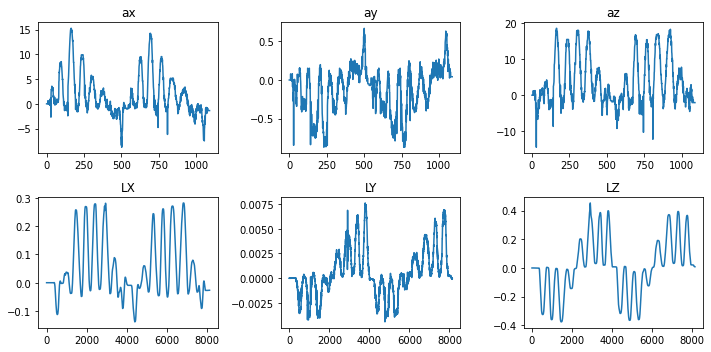

In [275]:
fig, ax = plt.subplots(2,3)
# Note that ax is now an array consisting of the individual axis

ax[0,0].plot(kinect_df[22]['ax'])
ax[0,0].set_title('ax')
ax[0,1].plot(kinect_df[22]['ay'])
ax[0,1].set_title('ay')
ax[0,2].plot(kinect_df[22]['az'])
ax[0,2].set_title('az')
ax[1,0].plot(df_mocap[22]['Skateboard_LX'])
ax[1,0].set_title('LX')
ax[1,1].plot(df_mocap[22]['Skateboard_LY'])
ax[1,1].set_title('LY')
ax[1,2].plot(df_mocap[22]['Skateboard_LZ'])
ax[1,2].set_title('LZ')

plt.tight_layout()

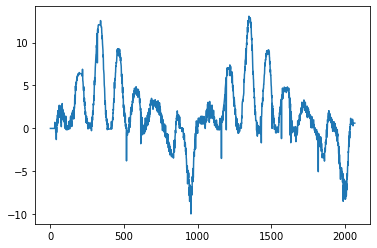

In [229]:
plt

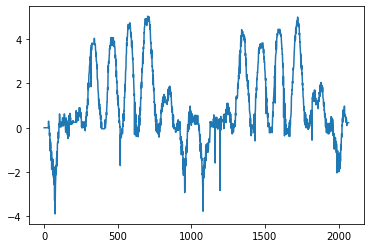

In [230]:

plt.plot(kinect_df[11]['ay'])

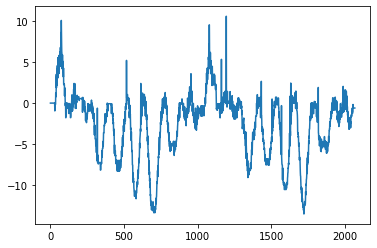

In [231]:

plt.plot(kinect_df[11]['az'])

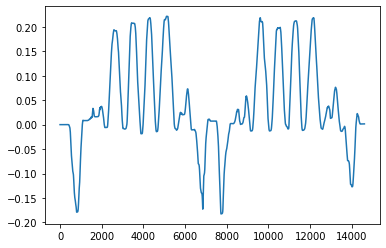

In [227]:
plt.plot(df_mocap[11]['Skateboard_LX'])

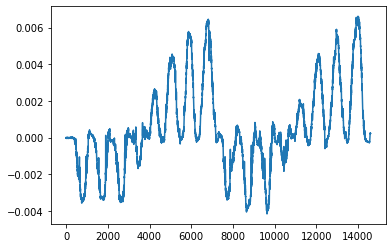

In [234]:
plt.plot(df_mocap[11]['Skateboard_LY'])

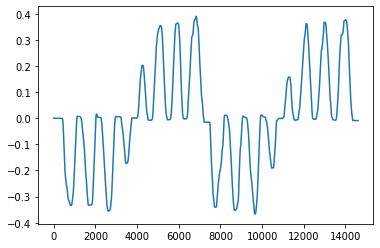

In [235]:
plt.plot(df_mocap[11]['Skateboard_LZ'])

In [126]:
df_mocap[1].loc[5].values.squeeze()

array(['0', '0.000000', '0.092441', '0.164468', '0.062579', '-0.017257',
       '0.165684', '0.051018', '0.083905', '0.164741', '0.166770'],
      dtype=object)

In [88]:
df_mocap[1]


4,Frame,Time (Seconds),X,Y,Z,X,Y,Z,X,Y,Z
5,0,0.000000,0.092441,0.164468,0.062579,-0.017257,0.165684,0.051018,0.083905,0.164741,0.166770
6,1,0.010000,0.092433,0.164448,0.062575,-0.017271,0.165664,0.051016,0.083899,0.164706,0.166742
7,2,0.020000,0.092438,0.164440,0.062566,-0.017255,0.165676,0.051009,0.083886,0.164773,0.166751
8,3,0.030000,0.092440,0.164457,0.062561,-0.017261,0.165679,0.051008,0.083881,0.164756,0.166761
9,4,0.040000,0.092437,0.164437,0.062566,-0.017276,0.165668,0.051007,0.083878,0.164783,0.166752
...,...,...,...,...,...,...,...,...,...,...,...
14603,14598,145.980000,0.093966,0.164709,0.053681,-0.015778,0.166023,0.042988,0.086676,0.165099,0.157994
14604,14599,145.990000,0.093966,0.164685,0.053683,-0.015782,0.165999,0.042982,0.086668,0.165119,0.157992
14605,14600,146.000000,0.093972,0.164703,0.053685,-0.015772,0.165965,0.042996,0.086646,0.165102,0.157986
14606,14601,146.010000,0.093964,0.164674,0.053692,-0.015771,0.166015,0.042998,0.086676,0.165083,0.158002


In [89]:
kinect_df.head()

,kx,ky,kz,ax,ay,az
0,-35.0,-86.0,1305.0,-33.54105,-14.52648,46.430862
1,-35.0,-86.0,1307.0,-33.54105,-14.52648,46.430862
2,-35.0,-86.0,1310.0,-33.54105,-14.52648,46.430862
3,-35.0,-86.0,1306.0,-33.54105,-14.52648,46.430862
4,-35.0,-86.0,1307.0,-33.54105,-14.52648,46.430862


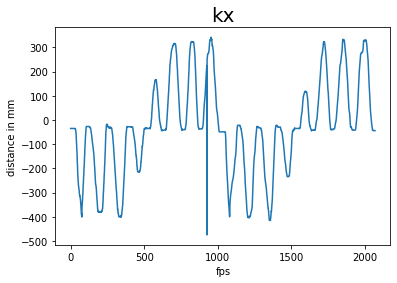

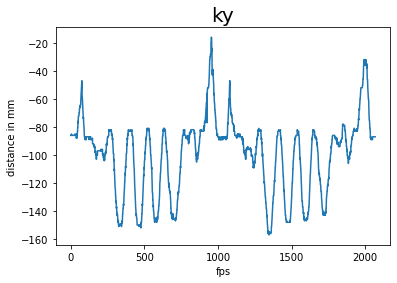

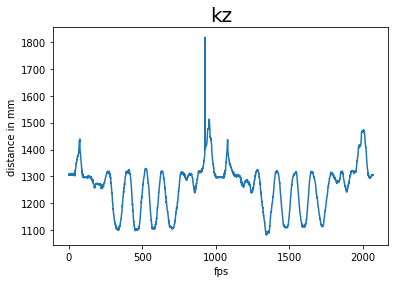

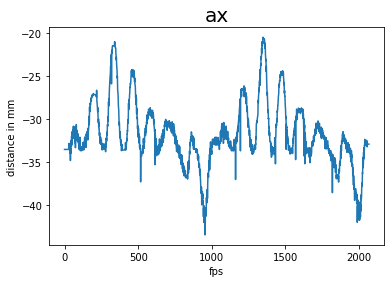

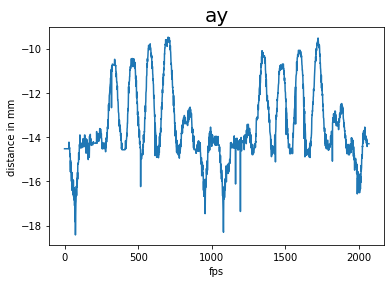

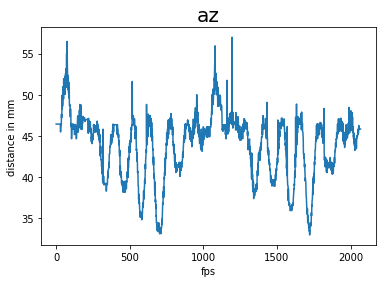

In [ ]:
label = ['kx', 'ky', 'kz', 'ax', 'ay', 'az']
for pos in label:
  plt.plot(kinect_df[pos])
  plt.xlabel('fps')
  plt.ylabel('distance in mm')
  plt.title(pos, fontsize=20)
  plt.show()

In [ ]:
print(translation_vectors)

None


array([[Timestamp('2021-07-03 13:06:40.174130'), nan],
       [Timestamp('2021-07-03 13:06:40.241936'), 0.067806],
       [Timestamp('2021-07-03 13:06:40.311387'), 0.069451],
       ...,
       [Timestamp('2021-07-03 13:09:02.521842'), 0.061488],
       [Timestamp('2021-07-03 13:09:02.586320'), 0.06447800000000001],
       [Timestamp('2021-07-03 13:09:02.660224'), 0.07390400000000001]],
      dtype=object)

In [ ]:
ls Subject\ 1/Subject\ 1

'Sub 1 MC.csv'  'Sub 1 SB'/


In [ ]:
print(df_sub1_mocap.columns[11])
# datetime.strptime(, "%H.%M.%S.%f")
datetime.strptime(df_sub1_mocap.columns[11], '%Y-%m-%d %H.%M.%S.%f %p')

2021-07-03 01.06.38.066 PM


datetime.datetime(2021, 7, 3, 1, 6, 38, 66000)

In [ ]:
df_sub1_mocap.columns[11]

'2021-07-03 01.06.38.066 PM'

In [ ]:
for video_no in range(1,2):
  with open("Subject "+str(video_no)+"/Subject "+str(video_no)+"/Sub "+str(video_no)+" MC.csv") as Mocap_data:
      df_sub1_mocap = pd.read_csv(Mocap_data)
      opti_time = datetime.strptime(df_sub1_mocap.columns[11], '%Y-%m-%d %H.%M.%S.%f %p')
      opti_stime = datetime.strptime( opti_time, "%H.%M.%S.%f")
      print(opti_stime)

TypeError: ignored

0.06673821733021096

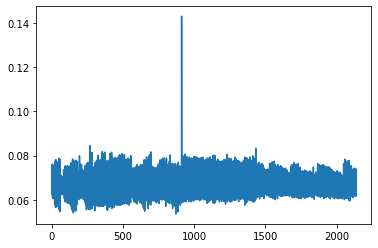

In [ ]:
plt.plot(time_sub1['Delta'].dt.total_seconds())
time_sub1['Delta'].dt.total_seconds().mean()

In [ ]:
framecount_of_videos = [2136, 1158, 1840]
(height, width, layers) = (368,432,3)
Depth_videos = {}
for video_no in range(2,3):
  Depth_xyz = np.empty((framecount_of_videos[video_no-1], height, width, layers))

  with open("Subject "+str(video_no)+"/Subject "+str(video_no)+"/Sub "+str(video_no)+" SB/xyz.pickle",'rb') as depthimg:
      i = 0
      while True:
          try:
              Depth_xyz[i] = pickle.load(depthimg)
              i = i+1
          except EOFError:
              Depth_videos[video_no] = Depth_xyz
              break

[array([-0.141, -0.251,  1.404]),
 array([[ 0.99871538, -0.02327689, -0.023868  ],
        [-0.00993747, -0.95835113, -0.27631295],
        [ 0.04968733,  0.27619518, -0.96077129]])]

In [ ]:
(height, width, layers) = (368,432,3)
fps=15.0
fourcc = cv2.VideoWriter_fourcc(*'MP42')
video = cv2.VideoWriter("Subject 3/Subject 3/Sub 3 SB/subject3_color.avi", fourcc, float(fps), (width, height))
# video = cv2.VideoWriter("'drive'/'MyDrive'/'Aruco CMC project'/'subject1.mp4'", fourcc, float(fps), (width, height))
i=0
with open("Subject 3/Subject 3/Sub 3 SB/color.pickle",'rb') as img:
    while True:
        try:
          # Change RGB to BGR
          video.write(cv2.cvtColor(pickle.load(img), cv2.COLOR_RGB2BGR))
          i = i+1
        except EOFError:
            break
video.release()

In [ ]:
# !ffmpeg -y -loglevel info -i subject3_color.avi subject3_color.mp4